In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from utils import PlaceFields, get_coords, to_tensor, gaussian_grid
from scipy.stats import multivariate_normal
from torch.optim import RMSprop
from torch.optim.lr_scheduler import ExponentialLR
from tqdm import tqdm

In [2]:
res = 400
coords = get_coords(res)

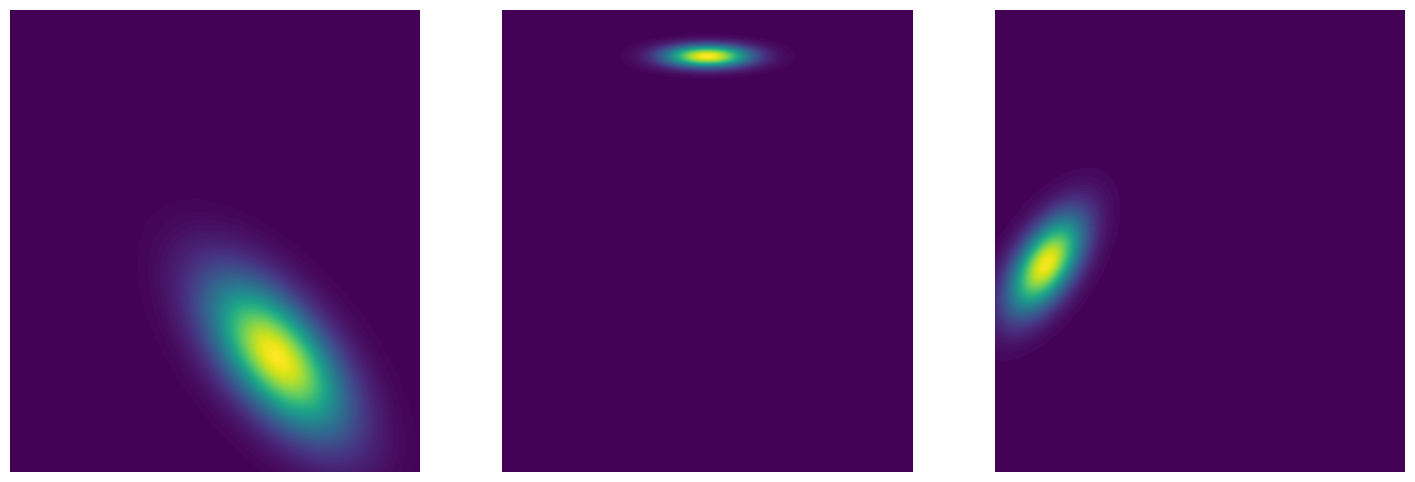

In [3]:
means = np.asarray([
    [0.3, -0.5],
    [0., 0.8],
    [-0.75, -0.1]
])
covs = np.asarray([
    [[0.05, -0.03],
     [-0.03, 0.05]],
    [[0.02, 0.],
     [0., 0.001]],
    [[0.015, 0.01],
     [0.01, 0.02]]
])


targets = [gaussian_grid(coords.cpu(), [multivariate_normal(mean=m, cov=cov)]) for m, cov in zip(means, covs)]

for ax, target in zip(plt.subplots(1, 3, figsize=(18, 6))[1], targets):
    ax.contourf(target, levels=100)
    ax.axis('off')
plt.show()

In [4]:
pfs = PlaceFields(coords, len(targets))
optim = RMSprop(pfs.parameters(), lr=1e-1)
scheduler = ExponentialLR(optim, gamma=0.8)

real = to_tensor(np.asarray(targets))

losses = list()
for i in tqdm(range(3000)):
    optim.zero_grad()
    loss = pfs(real)
    loss.backward()
    optim.step()
    losses.append(loss.detach().cpu().item())
    if i % 500 == 0 and i != 0:
        scheduler.step()

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:13<00:00, 222.40it/s]


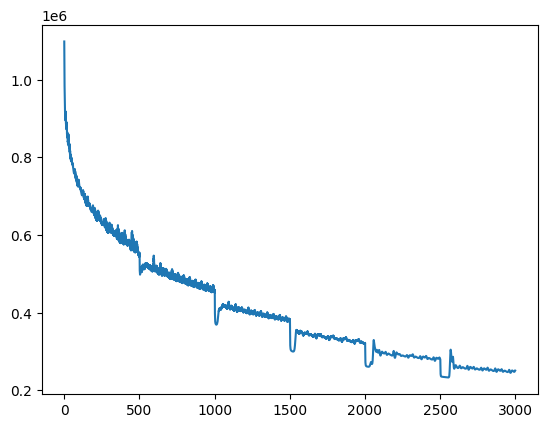

In [5]:
plt.plot(losses)

In [6]:
print("Prediction:")
print(pfs.means.data.cpu().numpy())
print("\nActual:")
print(means)

Prediction:
[[ 0.3163239  -0.48374137]
 [-0.02771267  0.815793  ]
 [-0.733824   -0.11644153]]

Actual:
[[ 0.3  -0.5 ]
 [ 0.    0.8 ]
 [-0.75 -0.1 ]]


In [7]:
torch.inverse(pfs.get_cov_inv()[1])

tensor([[2.0225e-02, 5.6323e-05],
        [5.6323e-05, 6.1304e-03]], device='cuda:0',
       grad_fn=<LinalgInvExBackward0>)

In [8]:
print("Prediction:")
print(torch.inverse(pfs.get_cov_inv()).detach().cpu().numpy())
print("\nActual:")
print(covs)

Prediction:
[[[ 5.0379507e-02 -2.9846933e-02]
  [-2.9846933e-02  5.0413698e-02]]

 [[ 2.0224815e-02  5.6323312e-05]
  [ 5.6323312e-05  6.1303596e-03]]

 [[ 1.5374056e-02  9.7680604e-03]
  [ 9.7680604e-03  2.0305352e-02]]]

Actual:
[[[ 0.05  -0.03 ]
  [-0.03   0.05 ]]

 [[ 0.02   0.   ]
  [ 0.     0.001]]

 [[ 0.015  0.01 ]
  [ 0.01   0.02 ]]]


In [9]:
print(pfs.scales.data.cpu().numpy())

[[ 3.9418676]
 [18.293158 ]
 [10.854433 ]]


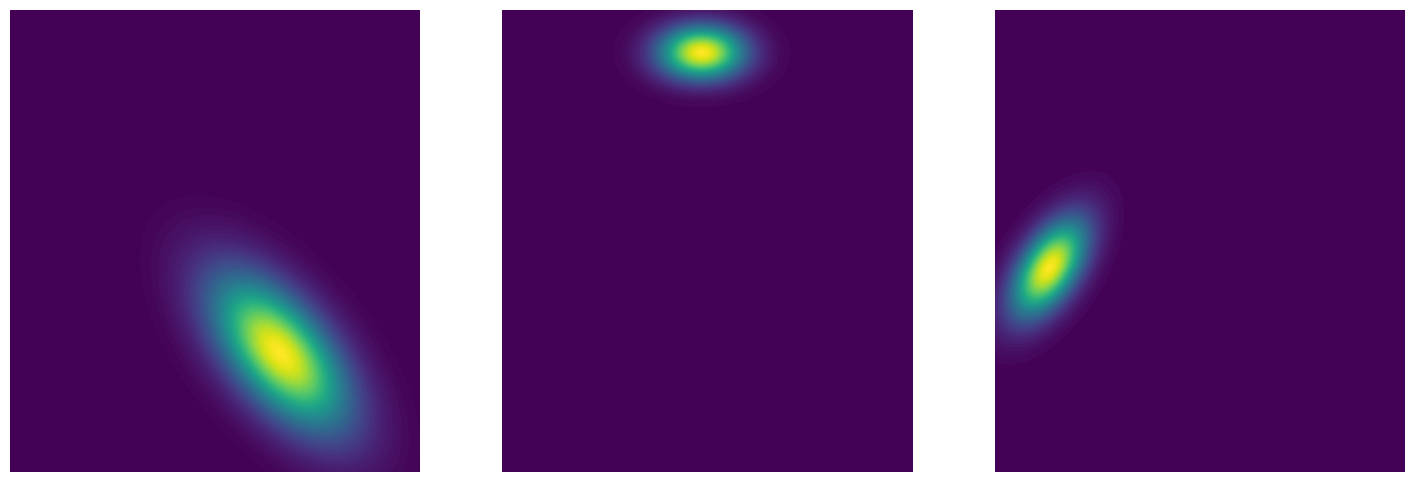

In [10]:
for ax, pred in zip(plt.subplots(1, 3, figsize=(18, 6))[1], pfs.predict().cpu().detach()):
    ax.contourf(pred, levels=100)
    ax.axis('off')
plt.show()